In [6]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from apoNN.src.datasets import ApogeeDataset

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

In [7]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


In [8]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut

In [9]:
cut_allStar = allStar[combined_cut]

### Parameters



In [11]:
n_batch = 64
n_z = 20
n_bins = 2000
lr = 0.001

### Training

In [12]:
dataset = ApogeeDataset(cut_allStar[0:5000])
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)

In [13]:
dataset[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0.3061, 0.3904]), 0)

In [14]:
encoder = Feedforward([n_bins,512,128,n_z],activation=nn.LeakyReLU()).to(device)
decoder = Feedforward([n_z,128,512,1024,2048,n_bins],activation=nn.LeakyReLU()).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [15]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/pretrained/ae1")


In [16]:
loss = nn.L1Loss()


In [17]:
for i in range(20000):
    for j,(x,u,idx) in enumerate(loader):

        optimizer_autoencoder.zero_grad()
        x_pred,z = autoencoder(x[:,1000:3000].to(device))

        err_pred = loss(x_pred,x[:,1000:3000].to(device))

        err_tot = err_pred
        err_tot.backward()
        optimizer_autoencoder.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")


err:0.01153428666293621,err_pred:0.01153428666293621


KeyboardInterrupt: 

In [ ]:
idx=15
#plt.plot(x_pred.detach().cpu().numpy()[idx])
plt.plot(x[:,1000:3000].detach().cpu().numpy()[idx])
plt.ylim(0.,1.3)
plt.xlim(0,1500)

## Latent Visualization

In [42]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    return z

In [43]:
def get_v(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [52]:
z_array = np.array([get_z(i,dataset).detach().cpu().numpy() for i in range(3000)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T

In [76]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["Mg_FE"],cut_allStar["C_FE"],cut_allStar["O_FE"]])[:,:8000].T
abundances_array = (abundances_array-np.min(abundances_array,axis=0))/(np.max(abundances_array,axis=0)-np.min(abundances_array,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [53]:
abundances_array = [dataset[i][1].cpu().numpy() for i in range(3000)]
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T


In [80]:
W_est =np.dot(abundances_calibrated[:,0:3000],np.linalg.pinv(z_calibrated))

In [85]:
abundances_calibrated_est = np.dot(W_est,z_calibrated)


In [91]:
abundances_calibrated[0,:3000].shape


(3000,)

(-0.1, 0.1)

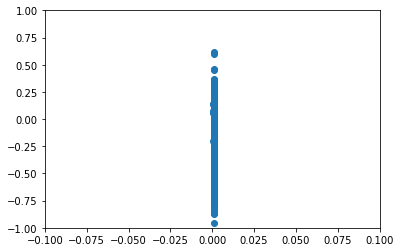

In [97]:
plt.scatter(abundances_calibrated[1,:3000],abundances_calibrated_est[0])
plt.ylim(-1,1)
plt.xlim(-0.1,0.1)


## Non-Linear Estimation

In [ ]:
n_z = z_calibrated.shape[0]
feedforward = Feedforward([n_z,512,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
v_index=0
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)
for i in range(10):
    for j,(x,u) in enumerate(loader):
        optimizer.zero_grad()
        _,z = autoencoder(x[:,1000:3000].to(device))
        pred = feedforward(z.detach())
        err = loss(pred,u[:,v_index:v_index+1].to(device))    
        err.backward()
        optimizer.step()
        if j%100==0:
            print(f"epoch:{i},err:{err}")


In [ ]:
v_array = np.array([get_v(i,dataset).detach().cpu().numpy() for i in range(3000)]).squeeze()


In [ ]:
normalized_abundances = (abundances_calibrated.T/(np.max(abundances_calibrated,axis=1)-np.min(abundances_calibrated,axis=1))).T

In [ ]:
plt.scatter(abundances_calibrated[0],v_array)

In [ ]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["Mg_FE"],cut_allStar["C_FE"],cut_allStar["O_FE"]])[:,:3000].T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T


In [ ]:
abundances_calibrated.shape

In [ ]:
abundances_calibrated.shape

In [ ]:
np.mean(abundances_array,axis=0).shape

## Non-linear better

### Setup

In [19]:
feedforward = Feedforward([n_z,512,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)


In [74]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["Mg_FE"],cut_allStar["C_FE"],cut_allStar["O_FE"]])[:,:8000].T
abundances_array = (abundances_array-np.min(abundances_array,axis=0))/(np.max(abundances_array,axis=0)-np.min(abundances_array,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [75]:
abundances_calibrated.shape

(6, 8000)

array([  994.41895, 10000.518  , 10000.757  , 10000.485  , 10000.814  ,
       10000.757  ], dtype=float32)

In [39]:
truth_tensor = torch.tensor(abundances_calibrated[0]).to(device)
truth_tensor = (truth_tensor-min(truth_tensor))/(max(truth_tensor)-min(truth_tensor))

In [40]:
for i in range(10):
    for j,(x,u,idx) in enumerate(loader):
        optimizer.zero_grad()
        _,z = autoencoder(x[:,1000:3000].to(device))
        pred = feedforward(z.detach())
        true = truth_tensor[idx]
        
        err = loss(pred,true)    
        err.backward()
        optimizer.step()
        if j%100==0:
            print(f"epoch:{i},err:{err}")


epoch:0,err:1.0089049339294434
epoch:1,err:0.05002707615494728
epoch:2,err:0.05402972549200058
epoch:3,err:0.0666762962937355
epoch:4,err:0.053569573909044266
epoch:5,err:0.05038310959935188
epoch:6,err:0.053832367062568665
epoch:7,err:0.06217329949140549
epoch:8,err:0.0650038793683052
epoch:9,err:0.0615139901638031


In [44]:
nonlinear_array = np.array([get_v(i,dataset).detach().cpu().numpy() for i in range(3000)]).squeeze()


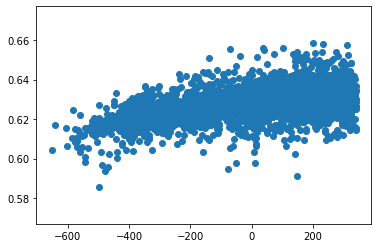

In [51]:
plt.scatter(abundances_calibrated[0][:3000],nonlinear_array[0:3000])

In [48]:
nonlinear_array.shape

(3000,)

In [50]:
abundances_calibrated[0][:3000]

SyntaxError: invalid syntax (<ipython-input-50-4f2772fa9b31>, line 1)